In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,account_type
0,we have sitting democrat us senator on trial f...,Right
1,marshawn lynch arrives to game in anti trump s...,Right
2,daughter of fallen navy sailor delivers powerf...,Right
3,just in president trump dedicates presidents c...,Right
4,respecting our national anthem standforouranthem,Right


In [3]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202315 entries, 0 to 202314
Data columns (total 2 columns):
text            202315 non-null object
account_type    202315 non-null object
dtypes: object(2)
memory usage: 3.1+ MB


In [4]:
x = my_df.text
y = my_df.account_type

In [5]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
from tqdm import tqdm
#tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

In [8]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

In [9]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [10]:
len(all_x_w2v)

202315

#### Distributed Bag of Words

In [11]:
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=1, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

/Users/computer/miniconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 202315/202315 [00:00<00:00, 1742083.50it/s]


In [12]:
%%time
for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha

100%|██████████| 202315/202315 [00:00<00:00, 2346444.72it/s]


CPU times: user 4min 15s, sys: 3.25 s, total: 4min 18s
Wall time: 4min 33s


In [13]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [14]:
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

In [15]:
clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)

/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
clf.score(validation_vecs_dbow, y_validation)

0.7281265447355413

In [17]:
model_ug_dbow.save('d2v_model_ug_dbow.doc2vec')
model_ug_dbow = Doc2Vec.load('d2v_model_ug_dbow.doc2vec')

In [18]:
model_ug_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

#### Distributed memory - concatenated

In [19]:
cores = multiprocessing.cpu_count()
model_ug_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmc.build_vocab([x for x in tqdm(all_x_w2v)])

/Users/computer/miniconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 202315/202315 [00:00<00:00, 1595735.43it/s]


In [20]:
%%time
for epoch in range(30):
    model_ug_dmc.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmc.alpha -= 0.002
    model_ug_dmc.min_alpha = model_ug_dmc.alpha

100%|██████████| 202315/202315 [00:00<00:00, 2507025.92it/s]


CPU times: user 7min 39s, sys: 51.8 s, total: 8min 31s
Wall time: 5min 4s


In [22]:
model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')

In [23]:
model_ug_dmc.wv.most_similar('blacklivesmatter')


[('marlenepinnoc', 0.600085973739624),
 ('blackpeoplebelike', 0.5984916687011719),
 ('copshootings', 0.5759905576705933),
 ('bayview', 0.5664960145950317),
 ('freefella', 0.5603440403938293),
 ('blackwomenaregorgeous', 0.559554934501648),
 ('policebrutality', 0.5565026998519897),
 ('survivingcompton', 0.5528383255004883),
 ('rosaparks', 0.5517685413360596),
 ('blacktwitter', 0.5496900081634521)]

In [24]:
model_ug_dmc.wv.most_similar('trump')

[('bepositive', 0.6405110359191895),
 ('detractors', 0.6370944380760193),
 ('austerity', 0.5803809762001038),
 ('trumps', 0.5713320970535278),
 ('rainews', 0.5609710216522217),
 ('whacko', 0.5527499318122864),
 ('bure', 0.5491324663162231),
 ('kyei', 0.5484522581100464),
 ('realdonaldt', 0.547576367855072),
 ('gagop', 0.5339516997337341)]

In [25]:
model_ug_dmc.wv.most_similar('hillary')

[('obam', 0.6191667318344116),
 ('crookedhillary', 0.5869184732437134),
 ('jeannemfr', 0.5861913561820984),
 ('hrc', 0.5811194181442261),
 ('jeanettejing', 0.5670366883277893),
 ('killary', 0.5629463791847229),
 ('firesign', 0.5525758266448975),
 ('hillaryclinton', 0.5461773872375488),
 ('dorian', 0.5415672063827515),
 ('votato', 0.5299184322357178)]

In [26]:
model_ug_dmc.wv.most_similar('trump')

[('bepositive', 0.6405110359191895),
 ('detractors', 0.6370944380760193),
 ('austerity', 0.5803809762001038),
 ('trumps', 0.5713320970535278),
 ('rainews', 0.5609710216522217),
 ('whacko', 0.5527499318122864),
 ('bure', 0.5491324663162231),
 ('kyei', 0.5484522581100464),
 ('realdonaldt', 0.547576367855072),
 ('gagop', 0.5339516997337341)]

In [27]:
model_ug_dmc.wv.most_similar(positive=['bigger', 'small'], negative=['big'])

[('cuter', 0.51545649766922),
 ('crafted', 0.44468358159065247),
 ('commander', 0.4290488660335541),
 ('sadder', 0.42540547251701355),
 ('stronger', 0.4188271462917328),
 ('quicker', 0.41688770055770874),
 ('cheaper', 0.4153549075126648),
 ('sostenitori', 0.4137251079082489),
 ('louder', 0.4133688807487488),
 ('weaker', 0.41242820024490356)]

In [28]:
y0_fox = model_ug_dmc.wv.similarity('fox', 'trump')
y0_hillary = model_ug_dmc.wv.similarity('hillary', 'trump')
y0_obama = model_ug_dmc.wv.similarity('obama', 'trump')
y0_president = model_ug_dmc.wv.similarity('president', 'trump')
y0_criminal = model_ug_dmc.wv.similarity('criminal', 'trump')
y0_taxes = model_ug_dmc.wv.similarity('taxes', 'trump')

In [29]:
train_vecs_dmc = get_vectors(model_ug_dmc, x_train, 100)
validation_vecs_dmc = get_vectors(model_ug_dmc, x_validation, 100)

In [30]:
clf = LogisticRegression()
clf.fit(train_vecs_dmc, y_train)

/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
clf.score(validation_vecs_dmc, y_validation)

0.5659911023232822

In [32]:
model_ug_dmc.save('d2v_model_ug_dmc.doc2vec')
model_ug_dmc = Doc2Vec.load('d2v_model_ug_dmc.doc2vec')
model_ug_dmc.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

#### Distributed memory (mean)

In [33]:
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(validation_vecs_dmm, y_validation)

/Users/computer/miniconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 202315/202315 [00:00<00:00, 2124863.50it/s]
/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/computer/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.652496292634701

In [34]:
model_ug_dmm.wv.most_similar('trump')

[('him', 0.8262977004051208),
 ('it', 0.8146343231201172),
 ('he', 0.8124476671218872),
 ('you', 0.8083059787750244),
 ('hillary', 0.8004218339920044),
 ('that', 0.7977581024169922),
 ('the', 0.7933000922203064),
 ('they', 0.7879745960235596),
 ('this', 0.7829478979110718),
 ('she', 0.7808768153190613)]

In [35]:
model_ug_dmm.wv.most_similar('hillary')

[('she', 0.8227502107620239),
 ('trump', 0.8004218339920044),
 ('he', 0.7783733606338501),
 ('her', 0.7783688306808472),
 ('hrc', 0.7767571210861206),
 ('it', 0.7683634161949158),
 ('you', 0.7667920589447021),
 ('him', 0.7522196769714355),
 ('the', 0.7493163347244263),
 ('that', 0.7488702535629272)]

In [36]:
x = model_ug_dmm.wv.most_similar('blacklivesmatter')

In [37]:
print(x)

[('blm', 0.6468650698661804), ('cops', 0.6323459148406982), ('trump', 0.5920842885971069), ('racist', 0.588814377784729), ('policebrutality', 0.5836731195449829), ('racism', 0.5762604475021362), ('black', 0.5746322870254517), ('it', 0.5738137364387512), ('this', 0.5668563842773438), ('again', 0.5588103532791138)]


In [38]:
model_ug_dmm.wv.most_similar('cnn')

[('media', 0.6729427576065063),
 ('fox', 0.6644992828369141),
 ('trump', 0.6575020551681519),
 ('it', 0.6553632616996765),
 ('hillary', 0.6430875062942505),
 ('msm', 0.6416670680046082),
 ('him', 0.6260520815849304),
 ('she', 0.6246818900108337),
 ('he', 0.612838864326477),
 ('potus', 0.6126385927200317)]

In [39]:
model_ug_dmm.wv.most_similar(positive=['man', 'woman'], negative=['king'])

[('teen', 0.7515121698379517),
 ('cop', 0.7218312621116638),
 ('girl', 0.7149872779846191),
 ('person', 0.6940773725509644),
 ('men', 0.6790602207183838),
 ('guy', 0.6759276986122131),
 ('ppl', 0.6666580438613892),
 ('people', 0.6592268943786621),
 ('officer', 0.6575053930282593),
 ('someone', 0.6572706699371338)]

In [40]:
y1_fox = model_ug_dmm.wv.similarity('fox', 'trump')
y1_hillary = model_ug_dmm.wv.similarity('hillary', 'trump')
y1_obama = model_ug_dmm.wv.similarity('obama', 'trump')
y1_president = model_ug_dmm.wv.similarity('president', 'trump')
y1_criminal = model_ug_dmm.wv.similarity('criminal', 'trump')
y1_taxes = model_ug_dmm.wv.similarity('taxes', 'trump')

#### Pretrained models with Word2Vec

In [41]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
model = api.load("glove-twitter-25")
model.wv.most_similar("news")
#corpus = api.load('text8')  # download the corpus and return it opened as an iterable
#corpus = api.load('fake-news') 

#model = Word2Vec(corpus)  # train a model from the corpus


#import gensim.downloader as api

# info = api.info()  # show info about available models/datasets
# model = api.load("glove-twitter-25")  # download the model and return as object ready for use
# model.most_similar("cat")

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [42]:
w1 = "women"
model.wv.most_similar (positive=w1)

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('female', 0.9010127186775208),
 ('woman', 0.8889437317848206),
 ('country', 0.8862813115119934),
 ('rich', 0.8808580636978149),
 ('small', 0.8800746202468872),
 ('their', 0.8799911141395569),
 ('african', 0.8782814741134644),
 ('indian', 0.8750442266464233),
 ('become', 0.8694701194763184),
 ('british', 0.8648213148117065)]

In [43]:
model.wv.most_similar("trump")

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('banks', 0.9113253355026245),
 ('warren', 0.9105228781700134),
 ('clinton', 0.8849892616271973),
 ('gates', 0.8760884404182434),
 ('founder', 0.8722785115242004),
 ('buffett', 0.8699301481246948),
 ('kerry', 0.8676391839981079),
 ('murdoch', 0.8675356507301331),
 ('reagan', 0.8649043440818787),
 ('newman', 0.8631280064582825)]

In [44]:
model.wv.most_similar("obama")

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('romney', 0.9566565155982971),
 ('president', 0.940095841884613),
 ('barack', 0.9376799464225769),
 ('clinton', 0.9285898804664612),
 ('says', 0.9087843298912048),
 ('bill', 0.9080009460449219),
 ('claims', 0.9074633717536926),
 ('hillary', 0.8889247179031372),
 ('talks', 0.8864544034004211),
 ('government', 0.8833804130554199)]

In [45]:
model.wv.most_similar("cnn")

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('bbc', 0.8624094724655151),
 ('cbs', 0.8599801659584045),
 ('nbc', 0.8452893495559692),
 ('obama', 0.8193671703338623),
 ('director', 0.8192765712738037),
 ('fbi', 0.8134415149688721),
 ('anonymous', 0.8126939535140991),
 ('yahoo', 0.8100578188896179),
 ('guardian', 0.8078844547271729),
 ('barack', 0.8056629300117493)]

In [46]:
y2_fox = model.wv.similarity('fox', 'trump')
y2_hillary = model.wv.similarity('hillary', 'trump')
y2_obama = model.wv.similarity('obama', 'trump')
y2_president = model.wv.similarity('president', 'trump')
y2_criminal = model.wv.similarity('criminal', 'trump')
y2_taxes = model.wv.similarity('taxes', 'trump')
y2_russia = model.wv.similarity('russia', 'trump')
y1_russia = model_ug_dmm.wv.similarity('russia', 'trump')
y0_russia = model_ug_dmc.wv.similarity('russia', 'trump')

/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/Users/computer/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call 

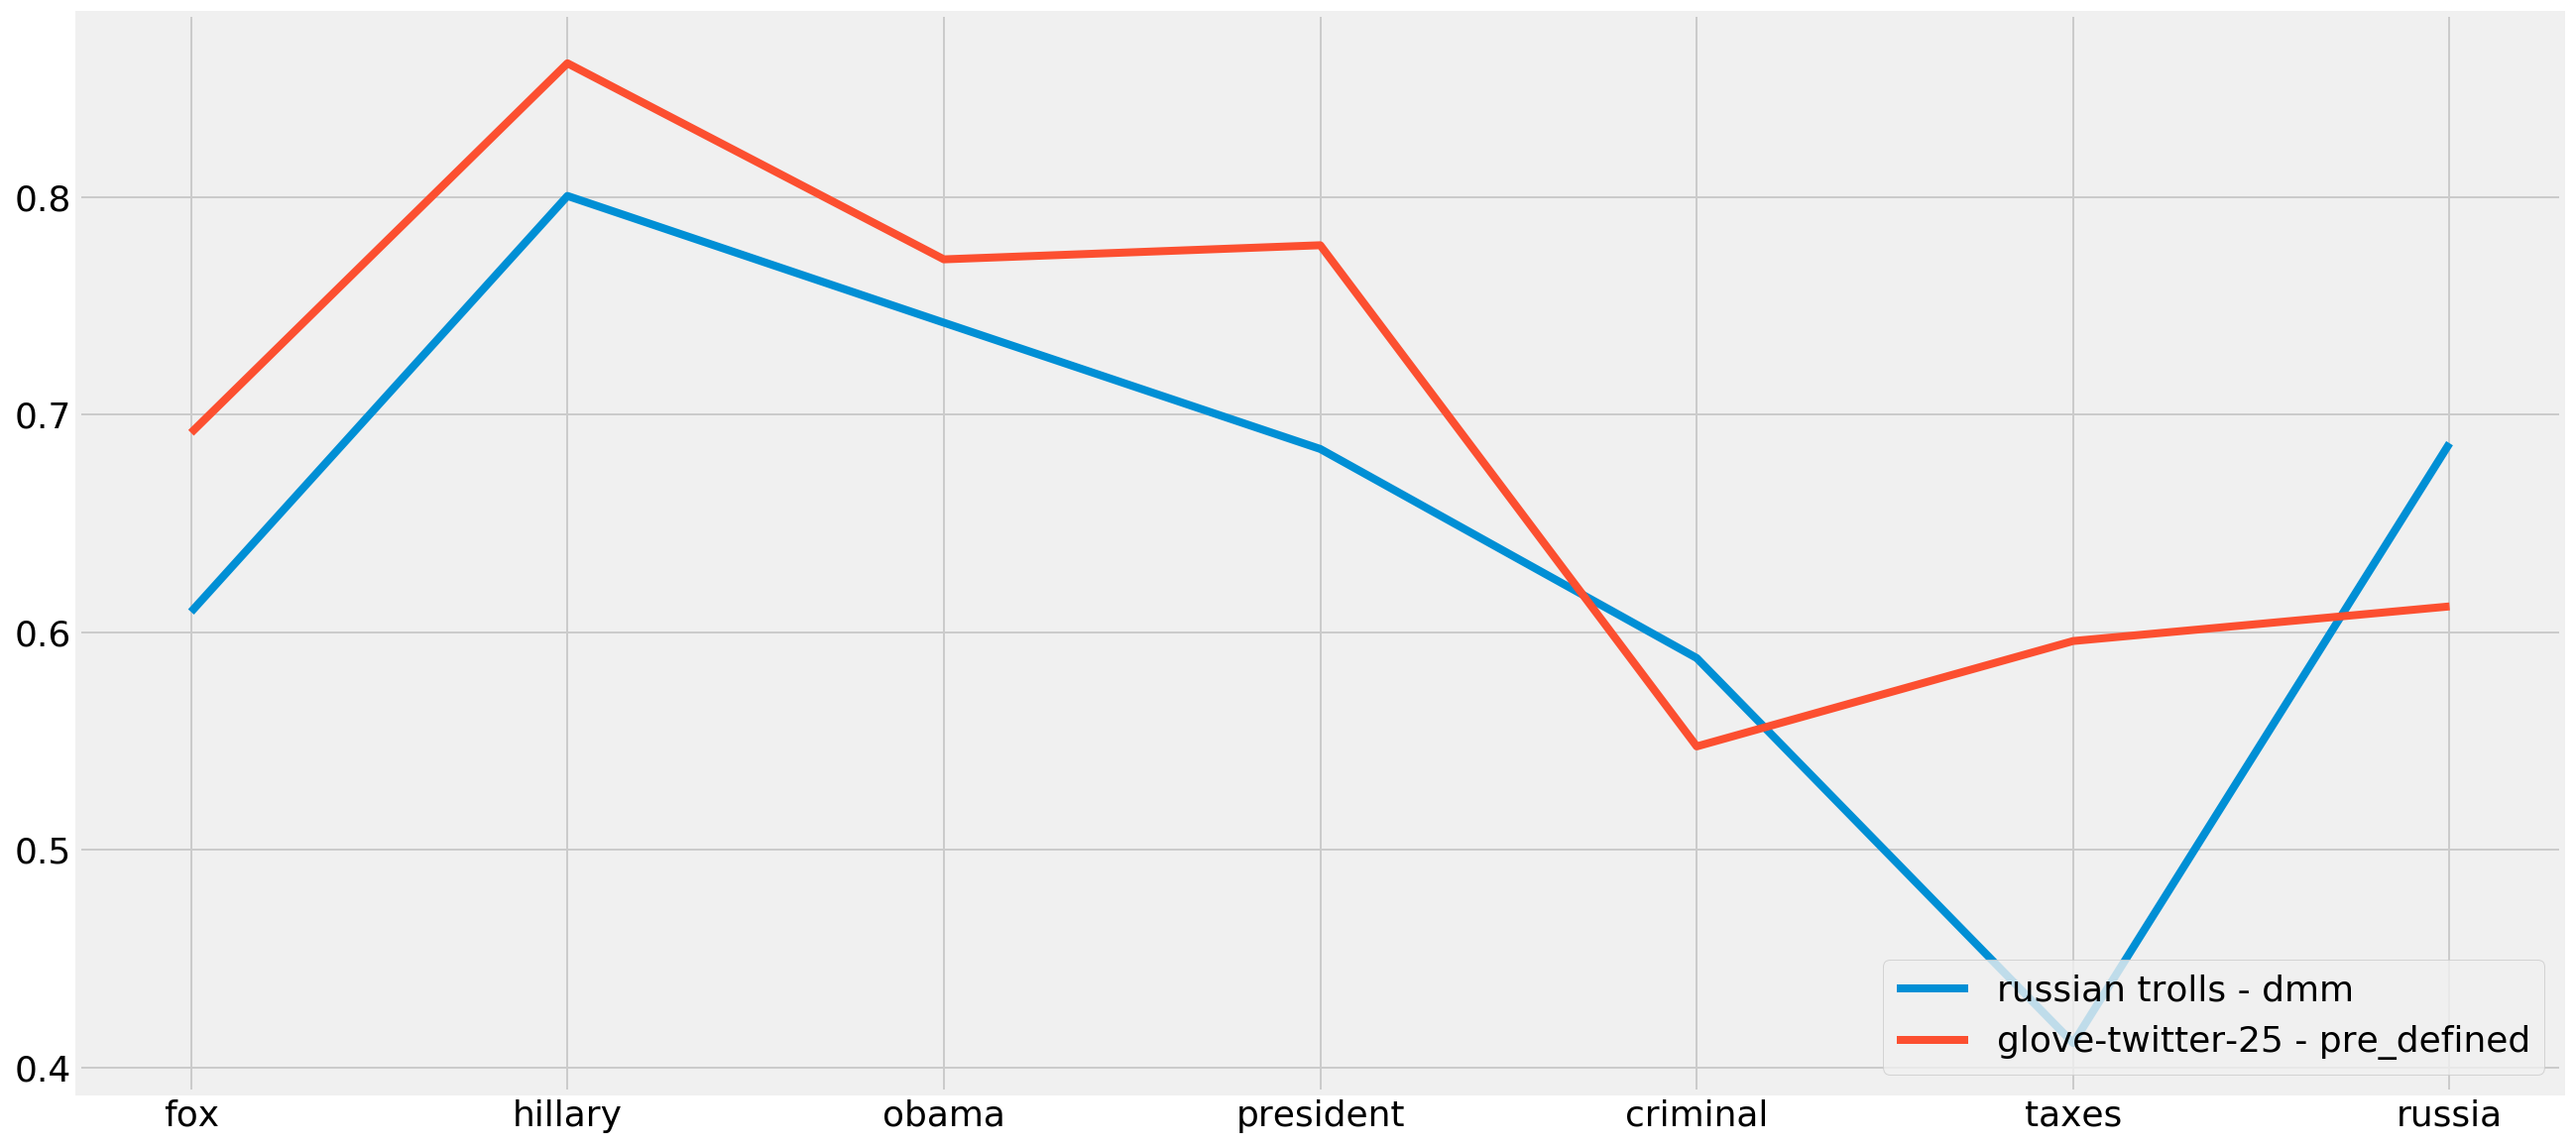

In [47]:
x = ['fox', 'hillary', 'obama', 'president','criminal','taxes','russia']
y2 = [y2_fox, y2_hillary, y2_obama, y2_president, y2_criminal, y2_taxes, y2_russia]
y1 = [y1_fox, y1_hillary, y1_obama, y1_president, y1_criminal, y1_taxes, y1_russia]
y0 = [y0_fox, y0_hillary, y0_obama, y0_president, y0_criminal, y0_taxes, y0_russia]
plt.figure(figsize=(20,10))
plt.rc('font', size=18) 
#plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
#plt.legend(['russian trolls - dmc', 'russian trolls - dmm','glove-twitter-25 - pre_defined'], loc=4)
plt.legend(['russian trolls - dmm','glove-twitter-25 - pre_defined'], loc=4)
plt.show()